In [1]:
import sys
import os
import importlib
import glob
import random
from itertools import combinations

import numpy as np
import scipy
import sklearn
import shap
import torch
from torch import nn

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

import mdtraj as md

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [3]:
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
cm_seq = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.9, dark=0.1, as_cmap=True, reverse=True
)
cm_seq2 = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.8, dark=0.1, as_cmap=True, reverse=False
)
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("", colors)

# Load Data

In [4]:
cv_trajs = list(
    np.load("../../data/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load("../../data/raw_feat/cv_dist_spin_anton2.npy"))

In [5]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_labels.append(f"{r} - {n}")

In [6]:
sb_trajs = list(np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load("../../data/raw_feat/feat2_raw_anton2.npy"))

In [7]:
cv_arr = np.concatenate(cv_trajs)
sb_arr = np.concatenate(sb_trajs)
print(cv_arr.shape, sb_arr.shape)

(4150115, 2) (4150115, 60)


In [8]:
# load committors
q = np.load("../../data/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[
    8
]  # 50 ns
w = np.load(
    "../../data/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True
)[0]

In [9]:
X = torch.Tensor(np.hstack((cv_arr, sb_arr)))
y = torch.Tensor(np.concatenate(q)).unsqueeze(-1)
print(X.shape, y.shape)

torch.Size([4150115, 62]) torch.Size([4150115, 1])


# Simple feedforward, single layer

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [11]:
class SingleLayerNet(nn.Module):
    """Neural network with a single hidden layer
    and sigmoid activation.
    """

    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SingleLayerNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.net(x)

In [12]:
input_dim = X.shape[-1]
hidden_dim = 30
output_dim = 1
net = SingleLayerNet(input_dim, hidden_dim, output_dim)

In [13]:
net.parameters

<bound method Module.parameters of SingleLayerNet(
  (net): Sequential(
    (0): Linear(in_features=62, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=1, bias=True)
    (3): Sigmoid()
  )
)>

In [16]:
train_X, test_X, train_y, test_y = sklearn.model_selection.train_test_split(
    X, y, test_size=0.2
)

In [17]:
train_X.shape, test_X.shape, train_y.shape, test_y.shape

(torch.Size([3320092, 62]),
 torch.Size([830023, 62]),
 torch.Size([3320092, 1]),
 torch.Size([830023, 1]))

In [18]:
class CommittorDataset(torch.utils.data.Dataset):
    def __init__(self, data, q):
        self.data = data
        self.q = q

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (self.data[idx], self.q[idx])

In [19]:
loss = nn.MSELoss()
opt = torch.optim.Adam(net.parameters())
epochs = 10
batch_size = 1024

In [20]:
# convert training/test data into batches
q_dataset = CommittorDataset(train_X, train_y)
batches = torch.utils.data.DataLoader(q_dataset, batch_size=batch_size, shuffle=True)

qtest_dataset = CommittorDataset(test_X, test_y)
test_batches = torch.utils.data.DataLoader(
    qtest_dataset, batch_size=batch_size, shuffle=False
)

In [107]:
# training loop
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss.item()


def test_loop(dataloader, model, loss_fn):
    test_loss = 0
    n_batches = len(dataloader)

    with torch.no_grad():
        for (X, y) in iter(dataloader):
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= n_batches
    print(
        f"Test Error: \n RMSE: {np.sqrt(test_loss):>7f}%, Avg loss: {test_loss:>8f} \n"
    )
    return test_loss

In [23]:
for t in range(epochs):
    print(f"Epoch {t}...")
    train_loop(batches, net, loss, opt)
    test_loop(test_batches, net, loss)

Epoch 0...
Epoch 1...
Epoch 2...
Epoch 3...
Epoch 4...
Epoch 5...
Epoch 6...
Epoch 7...
Epoch 8...
Epoch 9...


In [24]:
for p in net.parameters():
    print(p)

Parameter containing:
tensor([[ 0.2702,  0.0393,  0.2234,  ..., -0.0200, -0.0446, -0.1323],
        [ 0.1138, -0.0169,  0.1306,  ..., -0.1523, -0.3319,  0.0296],
        [ 0.0849, -0.0168,  0.2006,  ...,  0.1140, -0.5506,  0.0947],
        ...,
        [ 0.0019,  0.0035, -0.6165,  ...,  0.3406,  0.2272,  0.0735],
        [ 0.0397,  0.0034,  0.0942,  ..., -0.0666, -0.2578,  0.0442],
        [ 0.0101, -0.0428, -0.1349,  ..., -0.0754,  0.1999,  0.1559]],
       requires_grad=True)
Parameter containing:
tensor([ 0.4851,  0.0513, -0.2330,  0.0118,  0.2842,  0.4477, -0.1818,  0.4256,
        -0.4822, -0.3609,  0.4388,  0.2217, -0.2085, -0.3600,  0.3701,  0.2075,
        -0.4595, -0.1225, -0.2111,  0.4883, -0.2979, -0.3433, -0.8919, -0.3740,
        -0.0369,  0.2316, -0.2057, -0.2497, -0.4379,  0.2538],
       requires_grad=True)
Parameter containing:
tensor([[ 0.1786, -0.4029, -0.7522,  0.3277,  0.3641,  0.3417, -0.1902,  0.3871,
         -0.3106, -0.2982,  0.2285,  0.3577,  0.8045, -0.1334,

In [27]:
with torch.no_grad():
    for ex, true in zip(test_X[:10], test_y[:10]):
        print(f"Pred: {net(ex)}; True: {true}")

Pred: tensor([0.0811]); True: tensor([0.0831])
Pred: tensor([0.9061]); True: tensor([0.8946])
Pred: tensor([0.0321]); True: tensor([0.])
Pred: tensor([0.5808]); True: tensor([0.5338])
Pred: tensor([0.9288]); True: tensor([0.9338])
Pred: tensor([0.3464]); True: tensor([0.3325])
Pred: tensor([0.1519]); True: tensor([0.1485])
Pred: tensor([0.0472]); True: tensor([0.0802])
Pred: tensor([0.1016]); True: tensor([0.1064])
Pred: tensor([0.9407]); True: tensor([0.9306])


In [30]:
test_loop(test_batches, net, loss)

Test Error: 
 RMSE: 0.017090%, Avg loss: 0.000292 



0.00029206362566003475

In [22]:
# 5 fold cross-validation
k = 5
epochs = 10
batch_size = 8192
splits = sklearn.model_selection.KFold(n_splits=k, shuffle=True, random_state=123)
fold_perf = []

In [80]:
dataset = CommittorDataset(X, y)
for fold, (train_idx, test_idx) in enumerate(splits.split(np.arange(len(X)))):
    print(f"Fold {fold}----------------------")
    # sample using sklearn KFold split
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

    net = SingleLayerNet(input_dim, hidden_dim, output_dim)
    loss = nn.MSELoss()
    opt = torch.optim.Adam(net.parameters())

    # create batched data
    batches = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, sampler=train_sampler
    )
    test_batches = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, sampler=test_sampler
    )

    history = {"train_loss": [], "test_loss": []}

    # train model
    for t in range(epochs):
        print(f"Epoch {t}...")
        train_loss = train_loop(batches, net, loss, opt)
        test_loss = test_loop(test_batches, net, loss)
        print(
            f"Training loss: {train_loss:>7f}; Training RMSE: {np.sqrt(train_loss):>7f}"
        )
        print(f"Test loss: {train_loss:>7f}; Test RMSE: {np.sqrt(train_loss):>7f}")

        history["train_loss"].append(train_loss)
        history["test_loss"].append(test_loss)

    fold_perf.append(history)

Fold 0----------------------
Epoch 0...
loss: 0.083417  [    0/4150115]
loss: 0.006093  [819200/4150115]
loss: 0.003094  [1638400/4150115]
loss: 0.002559  [2457600/4150115]
loss: 0.002177  [3276800/4150115]
Test Error: 
 RMSE: 0.045433%, Avg loss: 0.002064 

Training loss: 0.001992; Training RMSE: 0.044633
Test loss: 0.001992; Test RMSE: 0.044633
Epoch 1...
loss: 0.002070  [    0/4150115]
loss: 0.001826  [819200/4150115]
loss: 0.001524  [1638400/4150115]
loss: 0.001350  [2457600/4150115]
loss: 0.001223  [3276800/4150115]
Test Error: 
 RMSE: 0.035026%, Avg loss: 0.001227 

Training loss: 0.001254; Training RMSE: 0.035414
Test loss: 0.001254; Test RMSE: 0.035414
Epoch 2...
loss: 0.001197  [    0/4150115]
loss: 0.001107  [819200/4150115]
loss: 0.001042  [1638400/4150115]
loss: 0.000966  [2457600/4150115]
loss: 0.000979  [3276800/4150115]
Test Error: 
 RMSE: 0.031318%, Avg loss: 0.000981 

Training loss: 0.000974; Training RMSE: 0.031202
Test loss: 0.000974; Test RMSE: 0.031202
Epoch 3...


In [87]:
test_rmse = []
for i, hist in enumerate(fold_perf[-5:]):
    print(f"Fold {i} statistics:")
    print("-------------------")
    print(
        f"Final training loss: {hist['train_loss'][-1]:.6f} / RMSE: {np.sqrt(hist['train_loss'][-1]):.4f}"
    )
    print(
        f"Final test loss: {hist['test_loss'][-1]:.6f} / RMSE: {np.sqrt(hist['test_loss'][-1]):.4f}"
    )
    test_rmse.append(np.sqrt(hist["test_loss"][-1]))
    print("====================")
print(f"Average test RMSE: {np.mean(test_rmse):.4f}")

Fold 0 statistics:
-------------------
Final training loss: 0.000595 / RMSE: 0.0244
Final test loss: 0.000605 / RMSE: 0.0246
Fold 1 statistics:
-------------------
Final training loss: 0.000902 / RMSE: 0.0300
Final test loss: 0.000862 / RMSE: 0.0294
Fold 2 statistics:
-------------------
Final training loss: 0.000636 / RMSE: 0.0252
Final test loss: 0.000632 / RMSE: 0.0251
Fold 3 statistics:
-------------------
Final training loss: 0.000941 / RMSE: 0.0307
Final test loss: 0.000917 / RMSE: 0.0303
Fold 4 statistics:
-------------------
Final training loss: 0.000485 / RMSE: 0.0220
Final test loss: 0.000512 / RMSE: 0.0226
Average test RMSE: 0.0264


# Bigger net

In [31]:
from typing import OrderedDict

In [37]:
class MultiLayerNet(nn.Module):
    """Neural network with a multiple hidden layer
    and sigmoid activation.
    """

    def __init__(self, input_dim, hidden_dim, output_dim, n_hidden=5):
        super(MultiLayerNet, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        for _ in range(n_hidden):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, output_dim))
        layers.append(nn.Sigmoid())
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [39]:
input_dim = X.shape[-1]
hidden_dim = 30
output_dim = 1
mlp = MultiLayerNet(input_dim, hidden_dim, output_dim)

In [40]:
mlp.parameters

<bound method Module.parameters of MultiLayerNet(
  (net): Sequential(
    (0): Linear(in_features=62, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): ReLU()
    (6): Linear(in_features=30, out_features=30, bias=True)
    (7): ReLU()
    (8): Linear(in_features=30, out_features=30, bias=True)
    (9): ReLU()
    (10): Linear(in_features=30, out_features=30, bias=True)
    (11): ReLU()
    (12): Linear(in_features=30, out_features=1, bias=True)
    (13): Sigmoid()
  )
)>

In [42]:
sum(p.numel() for p in mlp.parameters())

6571

In [44]:
sum(p.numel() for p in net.parameters())

1921

In [45]:
loss = nn.MSELoss()
opt = torch.optim.Adam(mlp.parameters())
epochs = 10
batch_size = 4096

In [46]:
# convert training/test data into batches
q_dataset = CommittorDataset(train_X, train_y)
batches = torch.utils.data.DataLoader(q_dataset, batch_size=batch_size, shuffle=True)

qtest_dataset = CommittorDataset(test_X, test_y)
test_batches = torch.utils.data.DataLoader(
    qtest_dataset, batch_size=batch_size, shuffle=True
)

In [49]:
for t in range(epochs):
    print(f"Epoch {t}...")
    train_loop(batches, mlp, loss, opt)
    test_loop(test_batches, mlp, loss)

Epoch 0...
loss: 0.000755  [    0/3320092]
loss: 0.000794  [409600/3320092]
loss: 0.000791  [819200/3320092]
loss: 0.000676  [1228800/3320092]
loss: 0.000667  [1638400/3320092]
loss: 0.000644  [2048000/3320092]
loss: 0.000688  [2457600/3320092]
loss: 0.000631  [2867200/3320092]
loss: 0.000635  [3276800/3320092]
Test Error: 
 RMSE: 0.024493%, Avg loss: 0.000600 

Epoch 1...
loss: 0.000624  [    0/3320092]
loss: 0.000640  [409600/3320092]
loss: 0.000635  [819200/3320092]
loss: 0.000581  [1228800/3320092]
loss: 0.000554  [1638400/3320092]
loss: 0.000556  [2048000/3320092]
loss: 0.000581  [2457600/3320092]
loss: 0.000590  [2867200/3320092]
loss: 0.000567  [3276800/3320092]
Test Error: 
 RMSE: 0.023209%, Avg loss: 0.000539 

Epoch 2...
loss: 0.000530  [    0/3320092]
loss: 0.000507  [409600/3320092]
loss: 0.000560  [819200/3320092]
loss: 0.000525  [1228800/3320092]
loss: 0.000520  [1638400/3320092]
loss: 0.000506  [2048000/3320092]
loss: 0.000565  [2457600/3320092]
loss: 0.000520  [2867200/

In [51]:
with torch.no_grad():
    for ex, true in zip(test_X[:20], test_y[:20]):
        print(f"Pred: {mlp(ex)}; True: {true}")
    for ex, true in zip(test_X[-20:], test_y[-20:]):
        print(f"Pred: {mlp(ex)}; True: {true}")

Pred: tensor([0.0776]); True: tensor([0.0831])
Pred: tensor([0.8887]); True: tensor([0.8946])
Pred: tensor([0.0198]); True: tensor([0.])
Pred: tensor([0.5341]); True: tensor([0.5338])
Pred: tensor([0.9191]); True: tensor([0.9338])
Pred: tensor([0.3382]); True: tensor([0.3325])
Pred: tensor([0.1489]); True: tensor([0.1485])
Pred: tensor([0.0261]); True: tensor([0.0802])
Pred: tensor([0.0947]); True: tensor([0.1064])
Pred: tensor([0.9377]); True: tensor([0.9306])
Pred: tensor([0.4805]); True: tensor([0.4926])
Pred: tensor([0.0675]); True: tensor([0.0650])
Pred: tensor([0.9041]); True: tensor([0.9031])
Pred: tensor([0.9046]); True: tensor([0.9268])
Pred: tensor([0.6026]); True: tensor([0.6184])
Pred: tensor([0.0581]); True: tensor([0.0310])
Pred: tensor([0.4889]); True: tensor([0.4580])
Pred: tensor([0.8676]); True: tensor([0.8861])
Pred: tensor([0.1733]); True: tensor([0.1686])
Pred: tensor([0.4193]); True: tensor([0.4154])
Pred: tensor([0.9003]); True: tensor([0.9055])
Pred: tensor([0.9

## training (5-fold CV)

In [53]:
# 5 fold cross-validation
k = 5
epochs = 10
batch_size = 8192
splits = sklearn.model_selection.KFold(n_splits=k, shuffle=True, random_state=123)
fold_perf = []
nets = []

In [66]:
dataset = CommittorDataset(X, y)
for fold, (train_idx, test_idx) in enumerate(splits.split(np.arange(len(X)))):
    print(f"----------------Fold {fold}----------------------")
    # sample using sklearn KFold split
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

    mlp = MultiLayerNet(input_dim, hidden_dim, output_dim, n_hidden=5)
    loss = nn.MSELoss()
    opt = torch.optim.Adam(mlp.parameters())

    # create batched data
    batches = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, sampler=train_sampler
    )
    test_batches = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, sampler=test_sampler
    )

    history = {"train_loss": [], "test_loss": []}

    # train model
    for t in range(epochs):
        print(f"Epoch {t}...")
        train_loss = train_loop(batches, mlp, loss, opt)
        test_loss = test_loop(test_batches, mlp, loss)
        # print(f"Training loss: {train_loss:>7f}; Training RMSE: {np.sqrt(train_loss):>7f}")
        # print(f"Test loss: {train_loss:>7f}; Test RMSE: {np.sqrt(train_loss):>7f}")

        history["train_loss"].append(train_loss)
        history["test_loss"].append(test_loss)

    fold_perf.append(history)
    nets.append(mlp)

    print("-----------------------------------------------------")

----------------Fold 0----------------------
Epoch 0...
loss: 0.139008  [    0/4150115]
loss: 0.008011  [819200/4150115]
loss: 0.002719  [1638400/4150115]
loss: 0.002203  [2457600/4150115]
loss: 0.002234  [3276800/4150115]
Test Error: 
 RMSE: 0.045375%, Avg loss: 0.002059 

Epoch 1...
loss: 0.002058  [    0/4150115]
loss: 0.001897  [819200/4150115]
loss: 0.001496  [1638400/4150115]
loss: 0.001586  [2457600/4150115]
loss: 0.001234  [3276800/4150115]
Test Error: 
 RMSE: 0.036263%, Avg loss: 0.001315 

Epoch 2...
loss: 0.001323  [    0/4150115]
loss: 0.001290  [819200/4150115]
loss: 0.001146  [1638400/4150115]
loss: 0.001038  [2457600/4150115]
loss: 0.000991  [3276800/4150115]
Test Error: 
 RMSE: 0.031679%, Avg loss: 0.001004 

Epoch 3...
loss: 0.000989  [    0/4150115]
loss: 0.000970  [819200/4150115]
loss: 0.000902  [1638400/4150115]
loss: 0.000916  [2457600/4150115]
loss: 0.000874  [3276800/4150115]
Test Error: 
 RMSE: 0.029730%, Avg loss: 0.000884 

Epoch 4...
loss: 0.000894  [    0/4

In [190]:
for i, n in enumerate(nets[-5:]):
    torch.save(n.state_dict(), f"nn_deep5_w30_{i}.dat")

In [71]:
with torch.no_grad():
    for i, n in enumerate(nets):
        print(f"Net {i}=====")
        for ex, true in iter(test_batches):
            print(f"Pred: {n(ex)}; True: {true}")

Net 0=====
Pred: tensor([[0.4999],
        [0.4998],
        [0.4999],
        ...,
        [0.5000],
        [0.4993],
        [0.4996]]); True: tensor([[0.7250],
        [0.5385],
        [0.2649],
        ...,
        [0.3275],
        [0.0452],
        [0.4569]])
Pred: tensor([[0.4997],
        [0.4994],
        [0.4999],
        ...,
        [0.5002],
        [0.4995],
        [0.4999]]); True: tensor([[0.4969],
        [0.0742],
        [0.1123],
        ...,
        [0.0400],
        [0.0932],
        [0.6736]])
Pred: tensor([[0.4998],
        [0.4991],
        [0.4988],
        ...,
        [0.4999],
        [0.4997],
        [0.4997]]); True: tensor([[0.6150],
        [0.9381],
        [0.9797],
        ...,
        [0.2202],
        [0.2491],
        [0.4791]])
Pred: tensor([[0.4991],
        [0.5003],
        [0.4984],
        ...,
        [0.5009],
        [0.4994],
        [0.4996]]); True: tensor([[0.9208],
        [0.7095],
        [0.9144],
        ...,
        [0.0447]

KeyboardInterrupt: 

In [79]:
with torch.no_grad():
    print(nets[2](X[0]), y[0])

tensor([0.4687]) tensor([0.0652])


# With standard preprocessing

In [99]:
from sklearn.preprocessing import StandardScaler

In [100]:
train_X, test_X, train_y, test_y = sklearn.model_selection.train_test_split(
    X, y, test_size=0.2
)

In [110]:
scaler = StandardScaler(copy=False)
train_X = scaler.fit_transform(train_X)
train_X = torch.from_numpy(train_X.astype(np.float32))

In [147]:
from joblib import dump, load

In [148]:
dump(scaler, "std_scaler_trainX.pkl", compress=3)

['std_scaler_trainX.pkl']

In [114]:
train_X

tensor([[-6.4247e-01, -1.6660e+00, -1.3329e+00,  ...,  1.7462e+00,
          2.0490e+00,  1.5424e+00],
        [-5.0266e-01, -8.9618e-01, -5.5821e-01,  ...,  1.1084e+00,
          4.1923e-01,  1.0739e+00],
        [-2.8131e-01, -2.1368e-01, -5.0874e-02,  ...,  3.6406e-01,
         -2.9416e-01,  3.1232e-01],
        ...,
        [ 3.3520e-02, -7.0490e-01, -8.8402e-01,  ...,  8.6227e-01,
          8.5712e-01,  6.0311e-01],
        [-5.8450e-01, -6.1129e-02,  3.0127e-01,  ...,  6.7876e-01,
          8.0391e-01,  9.9092e-01],
        [ 8.4331e-04, -5.4392e-01,  4.3143e-01,  ...,  1.0385e+00,
          7.0535e-01,  7.2194e-01]])

In [117]:
test_X = torch.from_numpy(scaler.transform(test_X).astype(np.float32))

In [118]:
train_y.dtype

torch.float32

In [111]:
epochs = 20
batch_size = 16384

net = SingleLayerNet(input_dim, hidden_dim, output_dim)
opt = torch.optim.Adam(net.parameters())

In [120]:
# convert training/test data into batches
q_dataset = CommittorDataset(train_X, train_y)
batches = torch.utils.data.DataLoader(q_dataset, batch_size=batch_size, shuffle=True)

qtest_dataset = CommittorDataset(test_X, test_y)
test_batches = torch.utils.data.DataLoader(
    qtest_dataset, batch_size=batch_size, shuffle=False
)

In [121]:
train_loss_hist, test_loss_hist = [], []
for t in range(epochs):
    print(f"Epoch {t}...")
    train_loss_hist.append(train_loop(batches, net, loss, opt))
    test_loss_hist.append(test_loop(test_batches, net, loss))

Epoch 0...
loss: 0.001695  [    0/3320092]
loss: 0.001474  [1638400/3320092]
loss: 0.001304  [3276800/3320092]
Test Error: 
 RMSE: 0.035705%, Avg loss: 0.001275 

Epoch 1...
loss: 0.001285  [    0/3320092]
loss: 0.001151  [1638400/3320092]
loss: 0.001060  [3276800/3320092]
Test Error: 
 RMSE: 0.032736%, Avg loss: 0.001072 

Epoch 2...
loss: 0.001077  [    0/3320092]
loss: 0.001023  [1638400/3320092]
loss: 0.000955  [3276800/3320092]
Test Error: 
 RMSE: 0.030990%, Avg loss: 0.000960 

Epoch 3...
loss: 0.000963  [    0/3320092]
loss: 0.000910  [1638400/3320092]
loss: 0.000870  [3276800/3320092]
Test Error: 
 RMSE: 0.029576%, Avg loss: 0.000875 

Epoch 4...
loss: 0.000893  [    0/3320092]
loss: 0.000844  [1638400/3320092]
loss: 0.000799  [3276800/3320092]
Test Error: 
 RMSE: 0.028272%, Avg loss: 0.000799 

Epoch 5...
loss: 0.000799  [    0/3320092]
loss: 0.000757  [1638400/3320092]
loss: 0.000736  [3276800/3320092]
Test Error: 
 RMSE: 0.027041%, Avg loss: 0.000731 

Epoch 6...
loss: 0.000

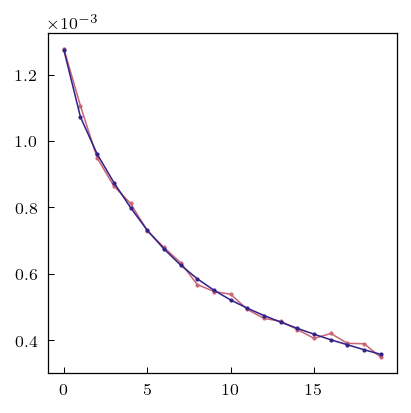

In [124]:
plt.plot(train_loss_hist, ".-")
plt.plot(test_loss_hist, ".-")

In [125]:
net.state_dict()

OrderedDict([('net.0.weight',
              tensor([[-0.2972,  0.0364, -0.2341,  ..., -0.0980,  0.3925, -0.4369],
                      [-0.0915,  0.0197,  0.1035,  ..., -0.0375, -0.0530,  0.0589],
                      [ 0.0211, -0.0827,  0.0930,  ...,  0.0993,  0.0101, -0.0631],
                      ...,
                      [ 0.1107, -0.0848,  0.1402,  ...,  0.0176,  0.1855,  0.0363],
                      [-0.0408, -0.0282,  0.0542,  ..., -0.0514, -0.1924, -0.0961],
                      [ 0.0687, -0.1252,  0.0711,  ...,  0.0271,  0.0546, -0.0655]])),
             ('net.0.bias',
              tensor([ 0.6673,  0.0172,  0.0052,  0.0800, -0.0010, -0.0518,  0.2112,  0.2113,
                       0.1880,  0.0116, -0.1056,  0.4089,  0.0033,  0.2353, -0.0622, -0.1418,
                       0.8836,  0.1579, -0.0905,  0.1722,  0.3134,  0.2127, -0.1274,  0.0402,
                       0.2004,  0.2071, -0.0611,  0.3990,  0.0369,  0.2183])),
             ('net.2.weight',
              ten

In [126]:
opt.state_dict()

{'state': {0: {'step': 4466,
   'exp_avg': tensor([[-5.8737e-07, -1.0016e-06,  3.8702e-06,  ...,  2.5609e-06,
            -7.7190e-07,  5.3031e-06],
           [-4.4051e-07,  3.4499e-07, -5.8892e-07,  ...,  6.4367e-07,
            -4.4819e-06,  9.1868e-08],
           [ 1.0610e-06,  8.7449e-07,  1.1968e-06,  ...,  1.5927e-08,
             2.3410e-06, -4.2272e-08],
           ...,
           [-6.9869e-07,  1.6858e-06, -1.0742e-06,  ..., -1.1718e-06,
            -3.3943e-07, -1.7305e-06],
           [-4.7037e-07, -3.5960e-07, -3.6442e-07,  ...,  2.7474e-06,
             3.6676e-06,  2.0927e-06],
           [ 5.8110e-07,  2.7965e-06,  5.5517e-07,  ..., -1.2396e-07,
            -5.1653e-07, -4.1510e-07]]),
   'exp_avg_sq': tensor([[1.0931e-09, 5.2870e-10, 7.1409e-10,  ..., 6.6527e-10, 1.0032e-09,
            9.9604e-10],
           [1.1799e-08, 1.3290e-08, 8.4747e-09,  ..., 1.3278e-08, 8.2992e-09,
            1.2694e-08],
           [5.9371e-09, 1.6802e-08, 6.0821e-09,  ..., 1.8083e-08, 1.

In [128]:
torch.save(
    {
        "epoch": 20,
        "model_state_dict": net.state_dict(),
        "optimizer_state_dict": opt.state_dict(),
        "loss": loss,
    },
    "nn_shallow_w30.dat",
)

## Increase learning rate

In [133]:
epochs = 20
batch_size = 16384

net2 = SingleLayerNet(input_dim, hidden_dim, output_dim)
lr = 0.004
opt = torch.optim.Adam(net2.parameters(), lr=lr)

In [134]:
train_loss_hist, test_loss_hist = [], []
for t in range(epochs):
    print(f"Epoch {t}...")
    train_loss_hist.append(train_loop(batches, net2, loss, opt))
    test_loss_hist.append(test_loop(test_batches, net2, loss))

Epoch 0...
loss: 0.169971  [    0/3320092]
loss: 0.002328  [1638400/3320092]
loss: 0.001365  [3276800/3320092]
Test Error: 
 RMSE: 0.036408%, Avg loss: 0.001326 

Epoch 1...
loss: 0.001300  [    0/3320092]
loss: 0.001030  [1638400/3320092]
loss: 0.000869  [3276800/3320092]
Test Error: 
 RMSE: 0.029540%, Avg loss: 0.000873 

Epoch 2...
loss: 0.000847  [    0/3320092]
loss: 0.000741  [1638400/3320092]
loss: 0.000634  [3276800/3320092]
Test Error: 
 RMSE: 0.025457%, Avg loss: 0.000648 

Epoch 3...
loss: 0.000642  [    0/3320092]
loss: 0.000562  [1638400/3320092]
loss: 0.000522  [3276800/3320092]
Test Error: 
 RMSE: 0.022829%, Avg loss: 0.000521 

Epoch 4...
loss: 0.000519  [    0/3320092]
loss: 0.000489  [1638400/3320092]
loss: 0.000439  [3276800/3320092]
Test Error: 
 RMSE: 0.021213%, Avg loss: 0.000450 

Epoch 5...
loss: 0.000439  [    0/3320092]
loss: 0.000423  [1638400/3320092]
loss: 0.000394  [3276800/3320092]
Test Error: 
 RMSE: 0.020081%, Avg loss: 0.000403 

Epoch 6...
loss: 0.000

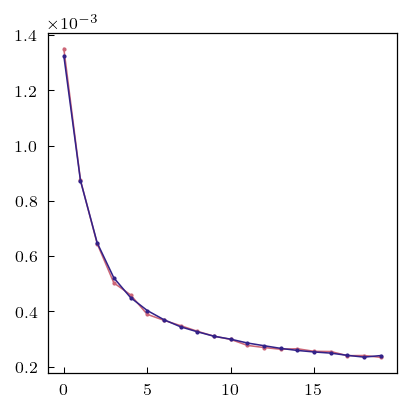

In [135]:
plt.plot(train_loss_hist, ".-")
plt.plot(test_loss_hist, ".-")

In [136]:
torch.save(
    {
        "epoch": 20,
        "model_state_dict": net2.state_dict(),
        "optimizer_state_dict": opt.state_dict(),
        "loss": loss,
    },
    "nn_shallow_w30_lr4.dat",
)

Text(0, 0.5, 'NN predicted $q_+$')

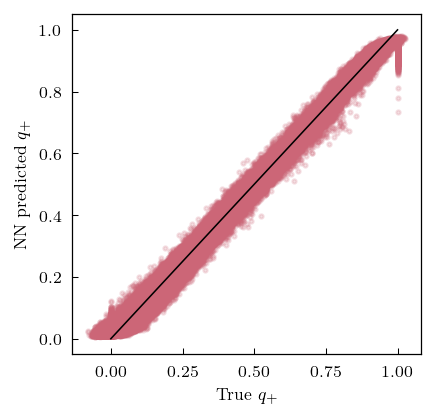

In [180]:
with torch.no_grad():
    pred_y = net2(test_X)
plt.scatter(test_y, pred_y, alpha=0.2)
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), "k")
plt.xlabel("True $q_+$")
plt.ylabel("NN predicted $q_+$")

# Validate/predict AMBER simulations

In [138]:
suppl_cv_trajs = []
suppl_cv_trajs.extend(
    np.load("../../data/raw_feat/cv_dist_spin_suppl_00.npy", allow_pickle=True)
)
suppl_cv_trajs.extend(
    np.load("../../data/raw_feat/cv_dist_spin_suppl_01.npy", allow_pickle=True)
)
suppl_cv_trajs.extend(
    np.load("../../data/raw_feat/cv_dist_spin_suppl_02.npy", allow_pickle=True)
)
suppl_sb_trajs = []
for i in range(6):
    suppl_sb_trajs.extend(
        np.load(f"../../data/raw_feat/feat2_suppl_{i:02d}.npy", allow_pickle=True)
    )

In [171]:
# load committors
q_predict = np.concatenate(
    np.load("../../data/feat2_dist_du_suppl_2/q_downup.npy", allow_pickle=True)[0][237:]
)
q_predict = torch.from_numpy(q_predict)
print(q_predict.shape)

torch.Size([729000])


In [154]:
predict_X = np.hstack(
    (np.concatenate(suppl_cv_trajs), np.concatenate(suppl_sb_trajs))
).astype(np.float32)
print(predict_X.shape)

(729000, 62)


In [155]:
predict_X_scaled = torch.from_numpy(scaler.transform(predict_X))
predict_X_scaled.shape

torch.Size([729000, 62])

In [191]:
with torch.no_grad():
    for mlp in nets[-5:]:
        predict_y = mlp(predict_X_scaled)
        rmse = np.sqrt(torch.mean((torch.squeeze(predict_y) - q_predict) ** 2))
        print(rmse)

tensor(0.0781, dtype=torch.float64)
tensor(0.0719, dtype=torch.float64)
tensor(0.0760, dtype=torch.float64)
tensor(0.0797, dtype=torch.float64)
tensor(0.0713, dtype=torch.float64)


Text(0, 0.5, 'NN predicted $q_+$')

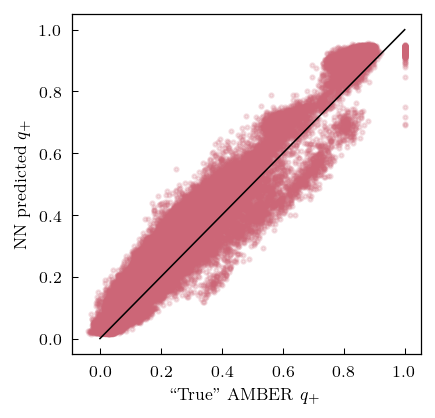

In [194]:
plt.scatter(q_predict[::10], predict_y[::10], alpha=0.2)
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), "k")
plt.xlabel("``True'' AMBER $q_+$")
plt.ylabel("NN predicted $q_+$")